## 💼 Problem Statement:

### You run an online campaign. 
* Out of 1000 visitors, 56 people clicked the ad (i.e., converted). 
#### You want to:
* Estimate the conversion rate
* Get a distribution instead of a point estimate
* Quantify uncertainty with credible intervals

### ________________________________________________

## Let's use Bayesian Inferencing technique to do the estimation of conversion rate
### Bayesian Modeling Setup

We model conversion as a <b> <i> binomial process </i> </b>:
* Likelihood: clicks ∼ Binomial(n=1000, p)
* Prior: Use a Beta prior (commonly used for probabilities). Say, p ∼ Beta(1,1) — a uniform prior.



In [4]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [5]:
# Observed data
n_visitors = 1000
n_conversions = 56

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
conversion_rate  0.057  0.007   0.044    0.071        0.0      0.0    2481.0   

                 ess_tail  r_hat  
conversion_rate    2611.0    1.0  


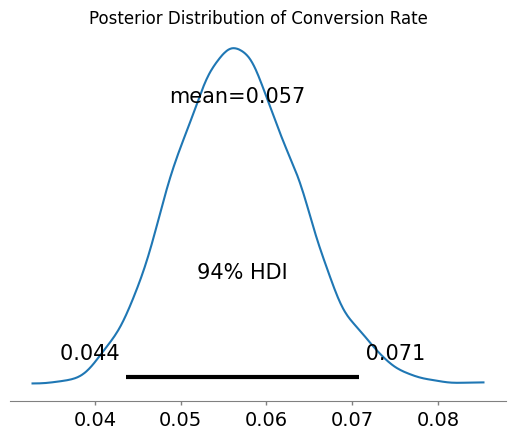

In [ ]:
with pm.Model() as model:
    # Prior belief about conversion rate: uniform (Beta(1,1)) is used as a non-informative prior
    # This can be adjusted based on prior knowledge
    # about the conversion rate
    # A Beta distribution is suitable for modeling probabilities
    # Here, we assume a uniform prior for the conversion rate
    # which is equivalent to Beta(1, 1)
    conversion_rate = pm.Beta("conversion_rate", alpha=1, beta=1)

    # Likelihood: observed data follows a Binomial distribution
    conversions = pm.Binomial("conversions", 
                              n=n_visitors, 
                              p=conversion_rate, 
                              observed=n_conversions)
    
    # Posterior sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)
    
# Posterior Summary
print(az.summary(trace, var_names=["conversion_rate"]))

# Posterior Plot
az.plot_posterior(trace, var_names=["conversion_rate"])
plt.title("Posterior Distribution of Conversion Rate")
plt.show()


In [8]:
conversion_rate

conversion_rate

### Understanding the process/steps

1. conversion_rate = pm.Beta("conversion_rate", alpha=1, beta=1) 
   
   ----> It defines a random variable called "conversion_rate" using a Beta distribution as the prior belief about the website’s true conversion rate.
2. Parameters of Beta Distribution: alpha=1, beta=1
   ----> These are shape parameters of Beta Distribution
   * alpha (aka "successes")
   * beta (aka "failures")
3. Interpretation
   * Beta(1,1) is a uniform distribution over [0,1] - no prior bias towards any conversion rate
   * You're saying: "Before seeing the data, I believe all values of conversion rate (from 0 to 1) are equally likely."
3. Examples of other priors:
   * Beta(1,1): Uniform - no preference
   * Beta(2,2): Prior belief the rate is around 0.5
   * Beta(10, 2): Prior belief the rate is probably high (closer to 0.8)
   * Beta(2, 10): Prior belief the rate is probably low (closer to 0.2)
   * Beta(0.5, 0.5): U-shaped, belief the rate is likely near 0 or 1, not middle

### In Bayesian terms:
* You define a prior distribution on the parameter p (conversion rate).
* You update it using observed data (clicks vs. non-clicks).
* The result is the posterior distribution, which reflects your updated belief.

___________________________________________________

## How to update the prior?
-- after we have the Historical Data available

-- this is what makes Bayesian modeling powerful: the ability to update your prior with data over time.

🔁 Scenario: You Have a Prior from Historical Data

* Let’s say you’ve run similar campaigns in the past and observed:

    * ~560 conversions out of 10,000 visitors
    * You can now encode this prior belief using a Beta distribution:

    * α = conversions + 1 = 560 + 1 = 561.
    * β = non-conversions + 1 = (10,000−560) + 1 = 9441

This gives you:
* conversion_rate = pm.Beta("conversion_rate", alpha=561, beta=9441)

This means:

* Your prior belief is already skewed toward a ~5.6% conversion rate
* New data will update this belief, not start from scratch

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


                  mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
conversion_rate  0.057  0.002     0.053      0.062        0.0      0.0   

                 ess_bulk  ess_tail  r_hat  
conversion_rate    2888.0    3074.0    1.0  


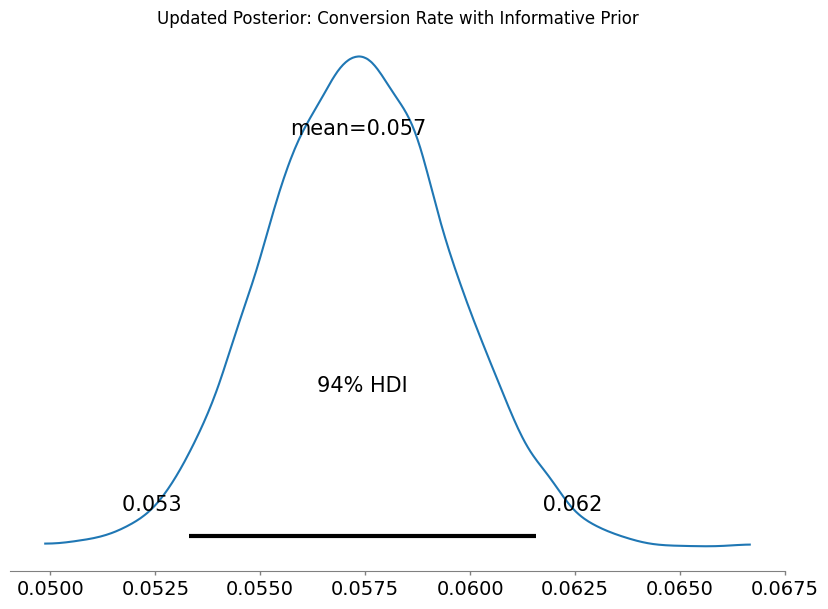

In [47]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# New observed data
new_visitors = 1000
new_conversions = 70

# Observed data from historical campaign
old_visitors = 10000
old_conversions = 560

# Prior from historical data
prior_alpha = old_conversions + 1 # successes + 1
prior_beta = old_visitors - old_conversions + 1 # failures + 1


with pm.Model() as updated_model:
    # Informative prior from historical data (based on previous campaign)
    conversion_rate = pm.Beta("conversion_rate", alpha=prior_alpha, beta=prior_beta)

    # Likelihood: new observed data
    conversions = pm.Binomial("conversions", 
                              n=new_visitors, 
                              p=conversion_rate, 
                              observed=new_conversions)
                            
    # Posterior inference
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)

# Posterior Summary
#print(az.summary(trace, var_names=["conversion_rate"]))
print(az.summary(trace, var_names=["conversion_rate"], hdi_prob=0.95)) # hdi_prob=0.95 sets the 95% of hdi (highest density interval))

# Posterior Plot
az.plot_posterior(trace, var_names=["conversion_rate"])
plt.title("Updated Posterior: Conversion Rate with Informative Prior")
plt.show()



What is HDI?

HDI stands for Highest Density Interval.

In Bayesian analysis, it's the Bayesian analog of a confidence interval, but with key differences in meaning and interpretation.

___________________________

### Let's understand how PyMC is running it using Mkarkov Chain Monte Carlo (MCMC)

* Frollowing line is key to running Bayesian inference using PyMC:
    * trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)

🔍 What It Does:

* This line draws samples from the posterior distribution using a Markov Chain Monte Carlo (MCMC) algorithm — usually No-U-Turn Sampler (NUTS) in PyMC by default.
* PyMC uses this to approximate the posterior, since it's usually not possible to solve analytically.

In [45]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

## Understanding Beta Distribution

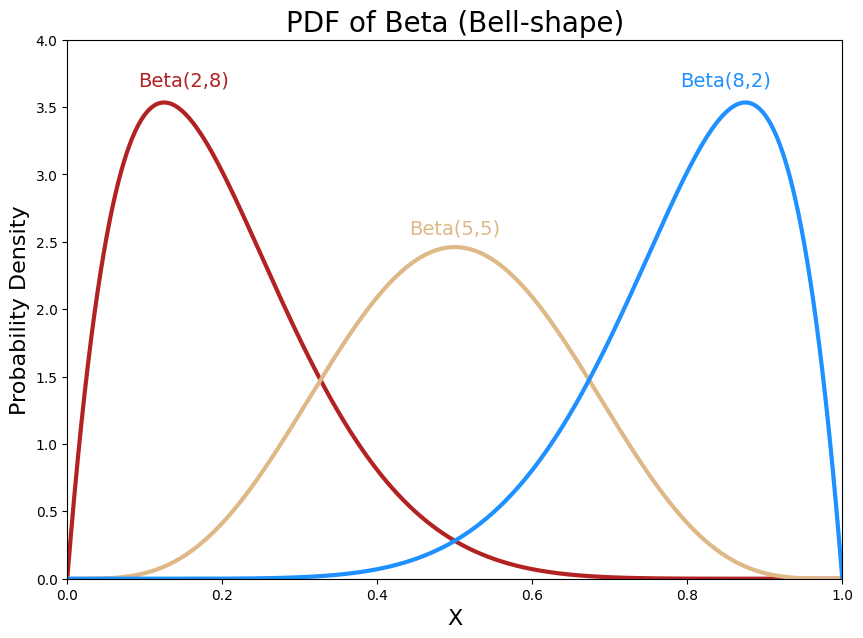

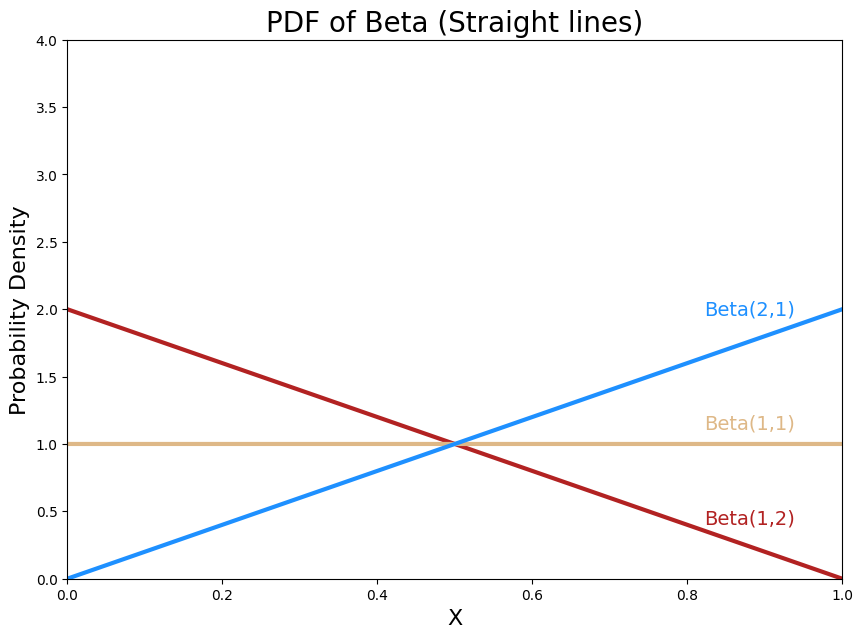

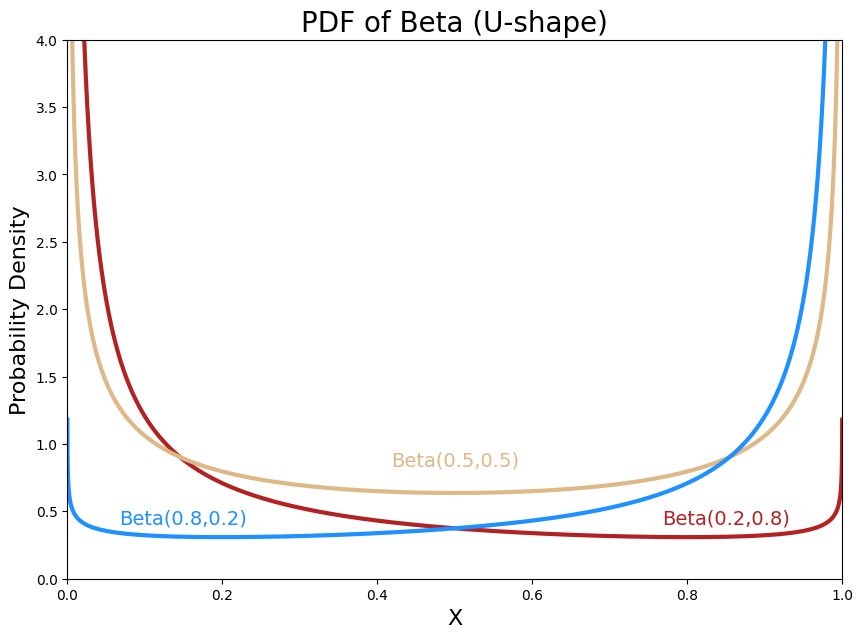

In [42]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]

# Bell shape
x = np.linspace(0, 1, 10000)
y1 = beta.pdf(x, 2, 8)
y2 = beta.pdf(x, 5, 5)
y3 = beta.pdf(x, 8, 2)

plt.title("PDF of Beta (Bell-shape)", fontsize=20)
plt.xlabel("X", fontsize=16)
plt.ylabel("Probability Density", fontsize=16)
plt.plot(x, y1, linewidth=3, color='firebrick')
plt.annotate("Beta(2,8)", xy=(0.15, 3.7), size = 14, ha='center', va='center', color='firebrick')
plt.plot(x, y2, linewidth=3, color='burlywood')
plt.annotate("Beta(5,5)", xy=(0.5, 2.6), size = 14, ha='center', va='center', color='burlywood')
plt.plot(x, y3, linewidth=3, color='dodgerblue')
plt.annotate("Beta(8,2)", xy=(0.85, 3.7), size = 14, ha='center', va='center', color='dodgerblue')
plt.ylim([0, 4])
plt.xlim([0, 1])
plt.show()

# Straight lines
x = np.linspace(0, 1, 10000)
y1 = beta.pdf(x, 1, 2)
y2 = beta.pdf(x, 1, 1)
y3 = beta.pdf(x, 2, 1)

plt.title("PDF of Beta (Straight lines)", fontsize=20)
plt.xlabel("X", fontsize=16)
plt.ylabel("Probability Density", fontsize=16)
plt.plot(x, y1, linewidth=3, color='firebrick')
plt.annotate("Beta(1,2)", xy=(0.88, 0.45), size = 14, ha='center', va='center', color='firebrick')
plt.plot(x, y2, linewidth=3, color='burlywood')
plt.annotate("Beta(1,1)", xy=(0.88, 1.15), size = 14, ha='center', va='center', color='burlywood')
plt.plot(x, y3, linewidth=3, color='dodgerblue')
plt.annotate("Beta(2,1)", xy=(0.88, 2.0), size = 14, ha='center', va='center', color='dodgerblue')
plt.ylim([0, 4])
plt.xlim([0, 1])
plt.show()

# U-shape
x = np.linspace(0, 1, 10000)
y1 = beta.pdf(x, 0.2, 0.8)
y2 = beta.pdf(x, 0.5, 0.5)
y3 = beta.pdf(x, 0.8, 0.2)

plt.title("PDF of Beta (U-shape)", fontsize=20)
plt.xlabel("X", fontsize=16)
plt.ylabel("Probability Density", fontsize=16)
plt.plot(x, y1, linewidth=3, color='firebrick')
plt.annotate("Beta(0.2,0.8)", xy=(0.85, 0.45), size = 14, ha='center', va='center', color='firebrick')
plt.plot(x, y2, linewidth=3, color='burlywood')
plt.annotate("Beta(0.5,0.5)", xy=(0.5, 0.88), size = 14, ha='center', va='center', color='burlywood')
plt.plot(x, y3, linewidth=3, color='dodgerblue')
plt.annotate("Beta(0.8,0.2)", xy=(0.15, 0.45), size = 14, ha='center', va='center', color='dodgerblue')
plt.ylim([0, 4])
plt.xlim([0, 1])
plt.show()
